# Classification

This page shows how I classified the Raman spectral data after denoised.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

## Import pre-processed data



In [2]:
all_denoised_data = pd.read_csv('all_denoised_data.csv', index_col=0)
all_denoised_data.shape

(520, 1557)

In [ ]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    mean = input_data.mean(axis=1)
    std = input_data.std(axis=1)
    for i in range(input_data.shape[0]):
        for j in range(input_data.shape[1]):
            # Apply correction
            data_snv[i:i+1,j] = (input_data.iat[i,j] - mean[i]) / std[i]
    return data_snv

In [3]:
X = all_denoised_data.drop(columns='diagnosis')
Y = all_denoised_data['diagnosis']

# Vector normalization
X1 = normalize(X)

# Standard Normal Variate Normalization
#X2 = snv(X)

# Encoding categorical data values
from sklearn.preprocessing import LabelEncoder
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)

In [66]:
# Split spectral data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y, test_size = 0.25, random_state=0)
X_train.shape


(390, 1556)

## Classification

In [50]:
from sklearn.decomposition import PCA
#Fit the spectral data and extract the explained variance ratio
pca1 = PCA(n_components=200)
trained_pca = pca1.fit_transform(X1)
var1 = pca1.explained_variance_ratio_
var = pd.DataFrame(var1, columns=['explained'])
var['cumulative'] = np.cumsum(var1)
var.head()

,explained,cumulative
0,0.279301,0.279301
1,0.137299,0.416601
2,0.089184,0.505784
3,0.045120,0.550905
4,0.033005,0.583909


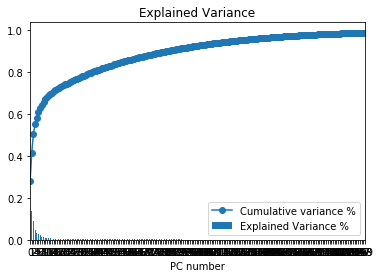

In [51]:
fig, ax = plt.subplots()
var['explained'].plot(kind='bar', label="Explained Variance %")
var['cumulative'].plot(kind='line',marker='o', label = 'Cumulative variance %')
ax.set_xlabel("PC number")
ax.set_title('Explained Variance')

plt.legend()
plt.show()

In [52]:
pca_result = pd.DataFrame(data=trained_pca)
pca_result['Cluster']=Y
pca_result.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Cluster
0,0.198104,-0.064456,-0.023549,-0.046459,0.023201,-0.006720,-0.001760,-0.005856,-0.038730,0.041221,...,-0.010618,-0.004079,0.009410,-0.009410,0.001440,0.002959,0.003976,-0.006142,-0.003726,0
1,0.191180,0.155099,-0.045514,-0.041782,0.043052,-0.024960,0.043987,0.017274,0.012293,0.041505,...,0.000415,-0.005865,0.001840,-0.001112,-0.000705,0.006228,0.000823,0.002508,0.004629,0
2,0.264329,-0.023958,-0.058427,-0.021067,0.035056,-0.020121,-0.045135,-0.000497,0.031779,0.023808,...,-0.003605,-0.004942,0.002093,-0.004831,0.005322,0.003231,0.004067,0.008912,-0.000444,0
3,0.060257,-0.127789,0.005265,-0.051063,-0.037622,0.056285,-0.005623,0.007804,0.036841,0.037576,...,-0.002015,0.014855,0.001852,0.001404,0.001708,0.000351,0.011237,-0.004073,0.005675,0
4,-0.045672,0.144162,0.072511,-0.029413,-0.033197,-0.071232,0.087658,0.042994,-0.047271,-0.040462,...,-0.004123,0.000038,-0.005452,0.014748,0.000264,-0.001850,0.006841,-0.003850,0.005320,0


Text(0, 0.5, 'PC1')

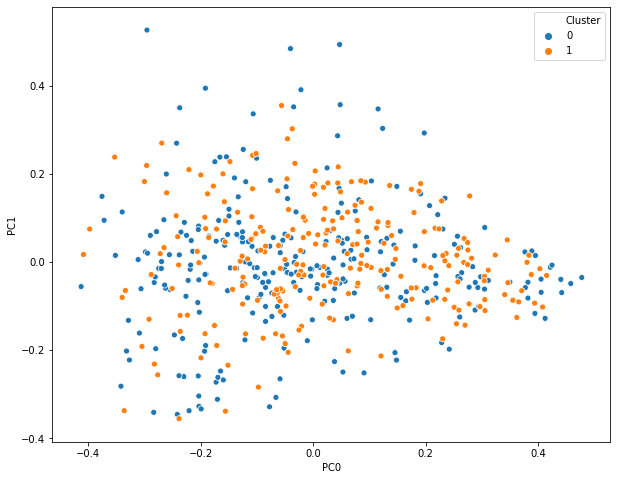

In [71]:
p = sns.scatterplot(x=pca_result[0], y=pca_result[1], hue=pca_result['Cluster'])
plt.xlabel('PC0')
plt.ylabel('PC1')

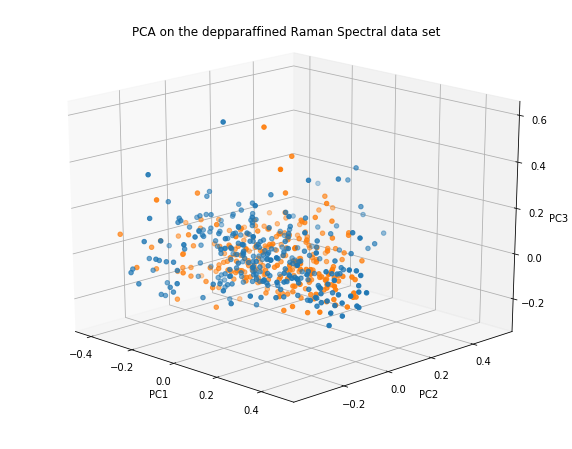

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = 10, 8
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca_neg = pca_result.loc[pca_result['Cluster']==0]
x1 = pca_neg[0]
y1 = pca_neg[1]
z1 = pca_neg[2]
pca_pos = pca_result.loc[pca_result['Cluster']==1]
x2 = pca_pos[0]
y2 = pca_pos[1]
z2 = pca_pos[2]

ax.scatter(x1,y1,z1)
ax.scatter(x2,y2,z2)

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the depparaffined Raman Spectral data set")
ax.view_init(elev=20., azim=-45)

plt.show()

In [53]:
# Define x and y
x = pca_result.drop(columns='Cluster')

# Split PC score
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.25, random_state=0)
x_train.shape

(390, 200)

#### Supoort Vector Machine

In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}    

grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, verbose=3) 
  
# fitting the model for grid search 
grid.fit(x_train, y_train) 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.588, total=   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.577, total=   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.550, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.542, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.546, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.543, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ...........

[CV] ................ C=1000, gamma=0.0001, score=0.546, total=   0.0s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.543, total=   0.0s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.6s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [62]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 0.01}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [63]:
grid_pred = grid.predict(x_test)

print(list(grid_pred).count(0))
print(list(grid_pred).count(1))

74
56


In [64]:
print(grid.score(x_test, y_test))

0.6


In [65]:
pip install mlxtend 

Note: you may need to restart the kernel to use updated packages.


In [66]:
from mlxtend.plotting import plot_decision_regions

In [67]:
x_train_2 = np.array(x_train.iloc[:,0:2])
x_test_2 = np.array(x_test.iloc[:,0:2])
svm = SVC(kernel='rbf', C=10, gamma=1)
svm.fit(x_train_2, y_train)
print(svm.score(x_test_2,y_test))

0.5153846153846153


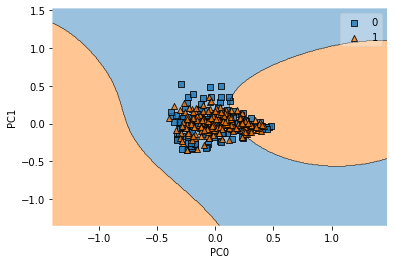

In [69]:
# Visualize the decision boundaries for PC1 and PC2
plot_decision_regions(x_train_2, y_train, clf=svm)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

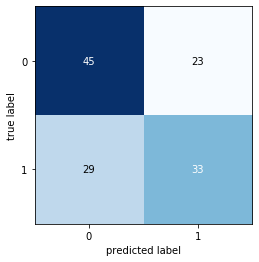

In [68]:
# plot condusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
matrix = confusion_matrix(y_test, grid_pred)
fig, ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()

|             | Predicted: Neg | Predicted: Pos |
|-------------|-------------------|-----------------------|
| Actual: Neg | True Negative (TN) | False Positive (FP)  |
| Actual: Pos | False Negative (FN) | True Positive (TP)   |

The predicted classes are represented in the columns of the matrix, whereas the actual classes are in the rows of the matrix. We then have four cases:

* True Negative (TN): the classifier predicted negative and the samples actually did not infect CWD.
* True Positive (TP): the classifier predicted postive and the samples actually infected CWD.
* False Negatives (FN): the classifier predicted negative but the samples actually infected CWD.
* False Positives (FP): tthe classifier predicted positive but the samples actually did not infect CWD.

#### Neural Network

In [9]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd

Using TensorFlow backend.


In [79]:
# Create model
model = Sequential()
model.add(Dense(3112, input_dim=1556, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1556, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(778, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(389, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(190, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(90, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(45, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
# Compile model    
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
   
# use raw data
# batch_size to 500 
# increase hidden layers 5 layers
# add dropout

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [83]:
# Fit model
model.fit(X_train, Y_train, batch_size=640, epochs=50, callbacks=callbacks_list, validation_data=(X_test, Y_test))

Train on 390 samples, validate on 130 samples
Epoch 1/50
390/390 [==============================] - 0s 838us/step - loss: 0.5267 - accuracy: 0.7590 - val_loss: 0.6829 - val_accuracy: 0.6615

Epoch 00001: val_accuracy did not improve from 0.69231
Epoch 2/50
390/390 [==============================] - 0s 738us/step - loss: 0.5130 - accuracy: 0.7538 - val_loss: 0.7515 - val_accuracy: 0.6769

Epoch 00002: val_accuracy did not improve from 0.69231
Epoch 3/50
390/390 [==============================] - 0s 767us/step - loss: 0.5314 - accuracy: 0.7513 - val_loss: 0.6959 - val_accuracy: 0.6615

Epoch 00003: val_accuracy did not improve from 0.69231
Epoch 4/50
390/390 [==============================] - 0s 870us/step - loss: 0.5023 - accuracy: 0.7821 - val_loss: 0.7163 - val_accuracy: 0.6462

Epoch 00004: val_accuracy did not improve from 0.69231
Epoch 5/50
390/390 [==============================] - 0s 758us/step - loss: 0.5022 - accuracy: 0.7949 - val_loss: 1.0187 - val_accuracy: 0.6308

Epoch 000


Epoch 00041: val_accuracy did not improve from 0.69231
Epoch 42/50
390/390 [==============================] - 0s 770us/step - loss: 0.5966 - accuracy: 0.6846 - val_loss: 0.6266 - val_accuracy: 0.6231

Epoch 00042: val_accuracy did not improve from 0.69231
Epoch 43/50
390/390 [==============================] - 0s 850us/step - loss: 0.5869 - accuracy: 0.6667 - val_loss: 0.6319 - val_accuracy: 0.6692

Epoch 00043: val_accuracy did not improve from 0.69231
Epoch 44/50
390/390 [==============================] - 0s 790us/step - loss: 0.5752 - accuracy: 0.7538 - val_loss: 0.6320 - val_accuracy: 0.6538

Epoch 00044: val_accuracy did not improve from 0.69231
Epoch 45/50
390/390 [==============================] - 0s 867us/step - loss: 0.5761 - accuracy: 0.6949 - val_loss: 0.6318 - val_accuracy: 0.6692

Epoch 00045: val_accuracy did not improve from 0.69231
Epoch 46/50
390/390 [==============================] - 0s 765us/step - loss: 0.5601 - accuracy: 0.7128 - val_loss: 0.6401 - val_accuracy: 0.

In [84]:
# load weights
model.load_weights("weights.best.hdf5")

In [87]:
# the prediction result will give the probability. 
Y_pred = model.predict(X_test)

# convert that probability into binary 0 and 1.
Y_pred = (Y_pred > 0.5)

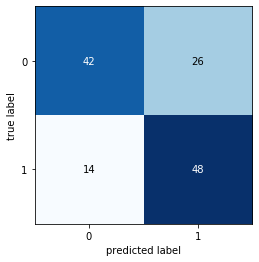

In [89]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

matrix = confusion_matrix(Y_test, Y_pred)
fig, ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()